## Project 5: Veggie Classification

We're going to build the image classification by using with veggie dataset. And we're planning to build the architect like below:

3*128*128 -> 784
784
784 -> 512
512
512 -> 256
256
256 -> 128
128 -> num_classes

In [1]:
!pip install torchvision

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

so, we import the basic packages next we're going to do some basic transformations like below:

In [3]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
#dataset
data_dir = "archive (4)/Vegetable Images"
train_data = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=transform)
val_data = datasets.ImageFolder(root=os.path.join(data_dir, "validation"), transform=transform)
test_data = datasets.ImageFolder(root=os.path.join(data_dir, "test"), transform=transform)

In [7]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

Defining the model like in below structure

3x128x128 -> 784 784 784 -> 512 512 512 -> 256 256 256 -> 128 128 -> num_classes

In [9]:
# 3. Define a model with regularization
class VeggieNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 128 * 128, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [10]:
model = VeggieNet(num_classes=len(train_data.classes))

Defining the loss and optimizer

In [11]:
criterion = nn.CrossEntropyLoss()

In [12]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

Traning and validating the model

In [28]:
for epoch in range(30):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    #validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {100 * correct / total:.2f}%")

Epoch 1, Train Loss: 0.2253, Val Loss: 0.3385, Val Accuracy: 90.70%
Epoch 2, Train Loss: 0.2311, Val Loss: 0.3053, Val Accuracy: 91.23%
Epoch 3, Train Loss: 0.2260, Val Loss: 0.3186, Val Accuracy: 91.03%
Epoch 4, Train Loss: 0.2190, Val Loss: 0.3488, Val Accuracy: 90.27%
Epoch 5, Train Loss: 0.2178, Val Loss: 0.3091, Val Accuracy: 91.10%
Epoch 6, Train Loss: 0.2101, Val Loss: 0.3186, Val Accuracy: 90.90%
Epoch 7, Train Loss: 0.2093, Val Loss: 0.3306, Val Accuracy: 91.07%
Epoch 8, Train Loss: 0.1897, Val Loss: 0.3325, Val Accuracy: 91.17%
Epoch 9, Train Loss: 0.1953, Val Loss: 0.3237, Val Accuracy: 91.37%
Epoch 10, Train Loss: 0.1835, Val Loss: 0.3629, Val Accuracy: 90.83%
Epoch 11, Train Loss: 0.1960, Val Loss: 0.3389, Val Accuracy: 90.70%
Epoch 12, Train Loss: 0.1848, Val Loss: 0.3354, Val Accuracy: 90.73%
Epoch 13, Train Loss: 0.1962, Val Loss: 0.3409, Val Accuracy: 90.60%
Epoch 14, Train Loss: 0.1817, Val Loss: 0.3353, Val Accuracy: 90.97%
Epoch 15, Train Loss: 0.1694, Val Loss: 0.3

In [29]:
# 7. Evaluate the model on the test set (with Confusion Matrix)
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 91.63%


Confusion Matrix

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

Confusion Matrix:


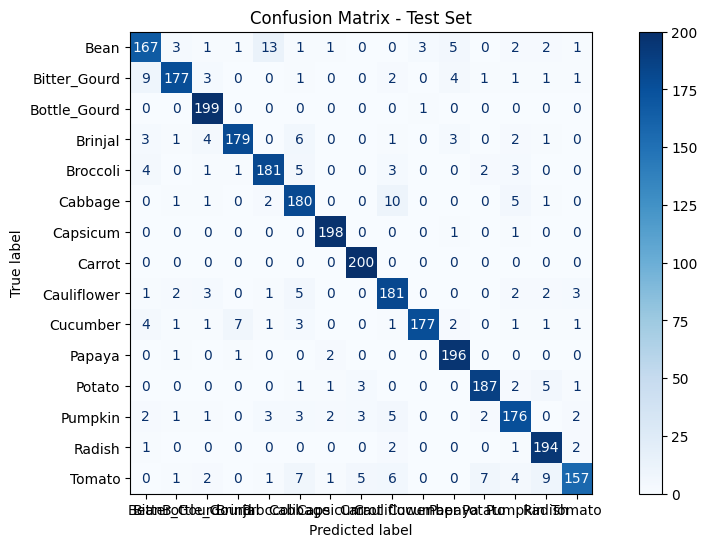

In [31]:
# Confusion Matrix Calculation
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.append(predicted.item())
        all_labels.append(labels.item())

cm = confusion_matrix(all_labels, all_preds)
class_names = test_data.classes
print("Confusion Matrix:")
# print(cm)

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(12, 6))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(ax=ax, cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()

Predicted: Papaya, Actual: Papaya


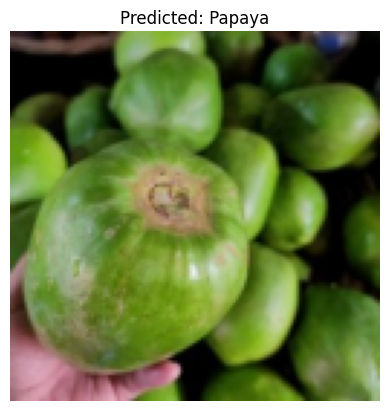

In [32]:
# 7. Test the model on one sample from the test set
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        class_names = test_data.classes
        print(f"Predicted: {class_names[predicted.item()]}, Actual: {class_names[labels.item()]}")
        plt.imshow(images[0].permute(1, 2, 0) * 0.5 + 0.5)  # unnormalize for display
        plt.title(f"Predicted: {class_names[predicted.item()]}")
        plt.axis('off')
        plt.show()
        break

Saving the model

In [33]:
torch.save(model.state_dict(), "veggie_net.pth")
print("Model saved!!")

Model saved!!
